In [1]:
# %%
# 导入必要库
import pandas as pd
import glob
import os

# %%
# 1. 定位所有 CSV 文件
base_dir = r"C:\Users\ZITIAO\Desktop\16-23 dataset"
file_paths = sorted(glob.glob(os.path.join(base_dir, "d*_v3.csv")))
print(f"共找到 {len(file_paths)} 个文件：")
for f in file_paths:
    print(" -", os.path.basename(f))


共找到 8 个文件：
 - d16_v3.csv
 - d17_v3.csv
 - d18_v3.csv
 - d19_v3.csv
 - d20_v3.csv
 - d21_v3.csv
 - d22_v3.csv
 - d23_v3.csv


In [3]:
def load_and_standardize(path):
    df = pd.read_csv(path)
    # 删除 _LABEL 列（大小写不敏感）
    mask_label = df.columns.str.upper().str.endswith(' LABEL') | df.columns.str.upper().str.endswith('_LABEL')
    df = df.loc[:, ~mask_label]
    # 打印原始列名
    print(f"\n--> 文件 {os.path.basename(path)} 原始列名 ({len(df.columns)} 列)：")
    print(df.columns.tolist())
    # 填充 QUANTITY RELEASED (kg) 空值
    if 'QUANTITY RELEASED (kg)' in df.columns:
        df['QUANTITY RELEASED (kg)'] = df['QUANTITY RELEASED (kg)'].fillna(0)
    # 删除 REGION 列中空值行
    if 'REGION' in df.columns:
        df = df[df['REGION'].notna()]
    # 规范列名
    df.columns = (
        df.columns
          .str.strip()
          .str.lower()
          .str.replace(' ', '_')
          .str.replace(r'[^0-9a-z_]', '', regex=True)
    )
    # 重命名关键列
    df = df.rename(columns={
        'primary_industry_activity_description': 'activity_description',
        'regulated_industry_subsector': 'regulated_industry_sub_sector',
        'reporting_threshold_kg': 'reporting_threshold',
        'quantity_released_kg': 'quantity_released',
        'quantity_released_(kg)': 'quantity_released'
    })
    # 删除规范化后含 _label 的列
    df = df.loc[:, ~df.columns.str.endswith('_label')]
    # 打印处理后列名
    print(f"--> 文件 {os.path.basename(path)} 处理后列名 ({len(df.columns)} 列)：")
    print(df.columns.tolist())
    # 增加年份列
    year = int(os.path.basename(path)[1:3]) + 2000
    df['year'] = year
    return df

In [5]:
# %%
# 3. 逐个文件加载并打印
all_dfs = []
for path in file_paths:
    df_standard = load_and_standardize(path)
    all_dfs.append(df_standard)


--> 文件 d16_v3.csv 原始列名 (18 列)：
['AUTHORISATION ID / PERMIT ID', 'PRIMARY INDUSTRY ACTIVITY DESCRIPTION', 'OPERATOR NAME', 'SITE ADDRESS', 'SITE POSTCODE', 'EASTING', 'NORTHING', 'EA AREA NAME', 'ROUTE NAME', 'SUBSTANCE NAME', 'REPORTING THRESHOLD (kg)', 'QUANTITY RELEASED (kg)', 'REGULATED INDUSTRY SECTOR', 'REGULATED INDUSTRY SUB SECTOR', 'PNEC (??g/L)', 'Latitude', 'Longitude', 'REGION']
--> 文件 d16_v3.csv 处理后列名 (18 列)：
['authorisation_id__permit_id', 'activity_description', 'operator_name', 'site_address', 'site_postcode', 'easting', 'northing', 'ea_area_name', 'route_name', 'substance_name', 'reporting_threshold', 'quantity_released', 'regulated_industry_sector', 'regulated_industry_sub_sector', 'pnec_gl', 'latitude', 'longitude', 'region']

--> 文件 d17_v3.csv 原始列名 (18 列)：
['AUTHORISATION ID / PERMIT ID', 'ACTIVITY DESCRIPTION', 'OPERATOR NAME', 'SITE ADDRESS', 'SITE POSTCODE', 'EASTING', 'NORTHING', 'EA AREA NAME', 'ROUTE NAME', 'SUBSTANCE NAME', 'REPORTING THRESHOLD (kg)', 'QUANTI

In [7]:
# 4. 合并数据并打印合并后的列名
data_all = pd.concat(all_dfs, ignore_index=True)
print(f"合并后数据：{data_all.shape[0]} 行, {data_all.shape[1]} 列")
# 打印合并后所有列名
print("合并后列名列表：")
print(data_all.columns.tolist())

# 筛选 Cypermethrin 并打印筛选后的列名
cyper = data_all[data_all['substance_name'] == 'Cypermethrin']
print(f"Cypermethrin 记录数：{len(cyper)}")
print("Cypermethrin 数据列名：")
print(cyper.columns.tolist())


合并后数据：4277 行, 19 列
合并后列名列表：
['authorisation_id__permit_id', 'activity_description', 'operator_name', 'site_address', 'site_postcode', 'easting', 'northing', 'ea_area_name', 'route_name', 'substance_name', 'reporting_threshold', 'quantity_released', 'regulated_industry_sector', 'regulated_industry_sub_sector', 'pnec_gl', 'latitude', 'longitude', 'region', 'year']
Cypermethrin 记录数：356
Cypermethrin 数据列名：
['authorisation_id__permit_id', 'activity_description', 'operator_name', 'site_address', 'site_postcode', 'easting', 'northing', 'ea_area_name', 'route_name', 'substance_name', 'reporting_threshold', 'quantity_released', 'regulated_industry_sector', 'regulated_industry_sub_sector', 'pnec_gl', 'latitude', 'longitude', 'region', 'year']


In [23]:
# %%
# 5. 填充描述性统计表格内容
# 设置显示完整表格
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# 计算基础统计量
desc = cyper['quantity_released'].describe(
    percentiles=[.05, .10, .25, .50, .75, .90, .95]
).rename({
    'mean': 'Mean',
    'std': 'Standard deviation',
    'min': 'Min',
    'max': 'Max',
    '5%': '5th Percentile',
    '10%': '10th Percentile',
    '25%': '25th Percentile',
    '50%': '50th Percentile',
    '75%': '75th Percentile',
    '90%': '90th Percentile',
    '95%': '95th Percentile',
    'count': 'Nb of Obs'
})
# 计算阈值相关
desc['Nb of obs below reporting threshold'] = (cyper['quantity_released'] < cyper['reporting_threshold']).sum()
# 站点统计
site_col = 'site_address' if 'site_address' in cyper.columns else cyper.columns[0]
desc['Nb of different sites'] = cyper[site_col].nunique()
# 站点年份
years_per_site = cyper.groupby(site_col)['year'].nunique()
desc['Mean nb years per sites'] = years_per_site.mean()
# 区域分布（占比）
regions = ['North East','North West','Yorkshire and The Humber','East Midlands',
           'West Midlands','East of England','London','South East','South West']
region_counts = cyper['region'].value_counts(normalize=True).reindex(regions, fill_value=0)
# 按区域写入
for r in regions:
    desc[f"Share of obs from {r}"] = region_counts[r]
# 年份分布（占比）
year_counts = cyper['year'].value_counts(normalize=True).sort_index()
for y in sorted(cyper['year'].unique()):
    desc[f"Share of samples from {y}"] = year_counts.get(y, 0)
# 企业类型（Wastewater companies）——基于 operator_name 关键字
wastewater_keywords = ["water", "wastewater", "sewerage"]
# 标记 operator_name 包含关键词的行
cyper['is_wastewater'] = (
    cyper['operator_name']
         .str.lower()
         .apply(lambda x: any(word in x for word in wastewater_keywords))
)
# 计算占比
wastewater_share = cyper['is_wastewater'].mean()
desc['Share of samples from wastewater companies'] = wastewater_share
# 整理输出表格
table = desc.to_frame('Cypermethrin').T
display(table)

C:\Users\ZITIAO\AppData\Local\Temp\ipykernel_5780\265246028.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cyper['is_wastewater'] = (


Nb of Obs      Mean  Standard deviation  Min  5th Percentile  \
Cypermethrin      356.0  0.420773             2.36808  0.0             0.0   

              10th Percentile  25th Percentile  50th Percentile  \
Cypermethrin              0.0              0.0              0.0   

              75th Percentile  90th Percentile  95th Percentile    Max  \
Cypermethrin             0.01          0.15875            1.135  31.35   

              Nb of obs below reporting threshold  Nb of different sites  \
Cypermethrin                                253.0                   98.0   

              Mean nb years per sites  Share of obs from North East  \
Cypermethrin                 3.489796                      0.053371   

              Share of obs from North West  \
Cypermethrin                      0.188202   

              Share of obs from Yorkshire and The Humber  \
Cypermethrin                                    0.449438   

              Share of obs from East Midlands  \
Cypermethrin                         0.070225   

              Share of obs from West Midlands  \
Cypermethrin                         0.036517   

              Share of obs from East of England  Share of obs from London  \
Cypermethrin                           0.061798                       0.0   

              Share of obs from South East  Share of obs from South West  \
Cypermethrin                      0.101124                      0.039326   

              Share of samples from 2016  Share of samples from 2017  \
Cypermethrin                    0.103933                    0.109551   

              Share of samples from 2018  Share of samples from 2019  \
Cypermethrin                    0.115169                    0.146067   

              Share of samples from 2020  Share of samples from 2021  \
Cypermethrin                    0.140449                    0.146067   

              Share of samples from 2022  Share of samples from 2023  \
Cypermethrin                    0.129213                    0.109551   

              Share of samples from wastewater companies  
Cypermethrin                                    0.078652

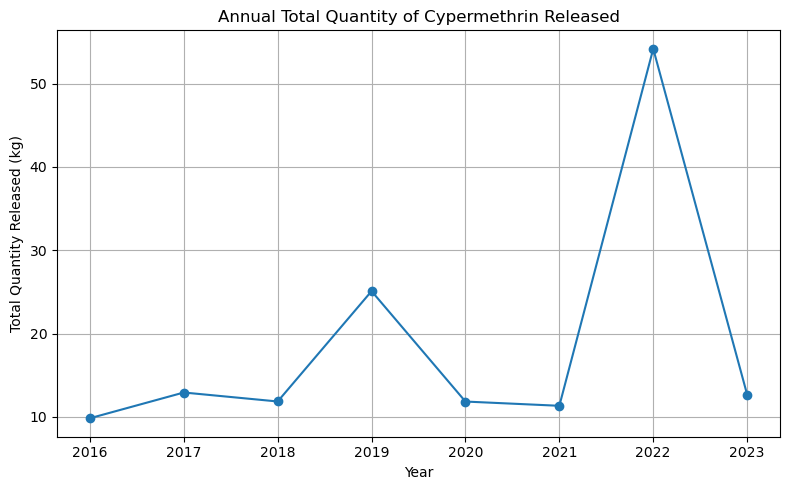

In [25]:
# %%
# 6. 年份趋势折线图 —— 展示每年Cypermethrin释放总量的变化
import matplotlib.pyplot as plt
# 按年度求和
yearly_totals = cyper.groupby('year')['quantity_released'].sum()
plt.figure(figsize=(8, 5))
plt.plot(yearly_totals.index, yearly_totals.values, marker='o')
plt.title('Annual Total Quantity of Cypermethrin Released')
plt.xlabel('Year')
plt.ylabel('Total Quantity Released (kg)')
plt.grid(True)
plt.tight_layout()
plt.show()

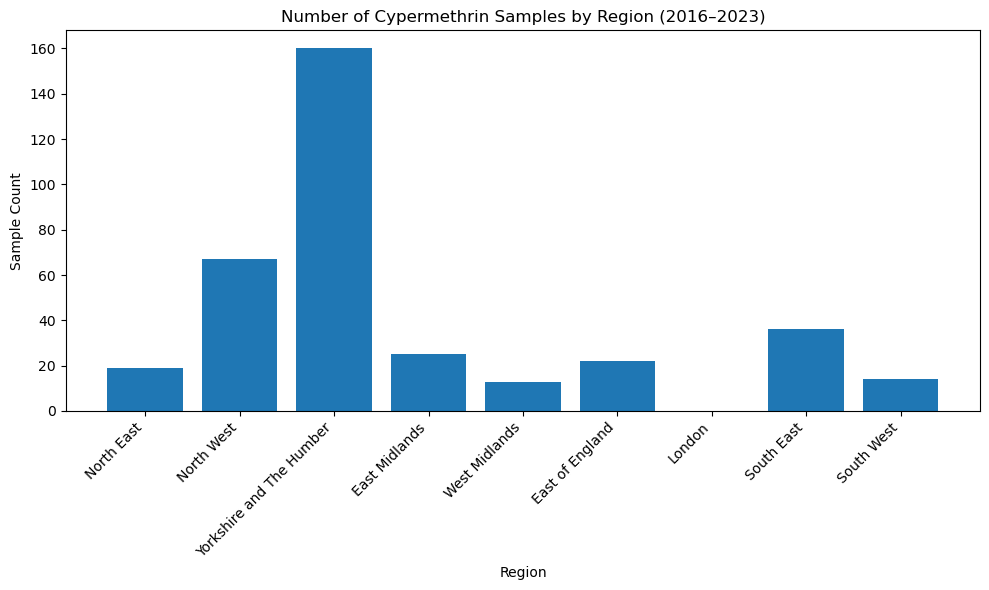

In [29]:
# %%
# 7. 区域分布柱状图 —— 展示2016-2023年各Region的Cypermethrin总释放量
regions_ordered = ['North East','North West','Yorkshire and The Humber','East Midlands',
           'West Midlands','East of England','London','South East','South West']
# 按Region计数，确保London即使为0也显示
counts_by_region = cyper['region'].value_counts().reindex(regions_ordered, fill_value=0)
plt.figure(figsize=(10, 6))
plt.bar(counts_by_region.index, counts_by_region.values)
plt.title('Number of Cypermethrin Samples by Region (2016–2023)')
plt.xlabel('Region')
plt.ylabel('Sample Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

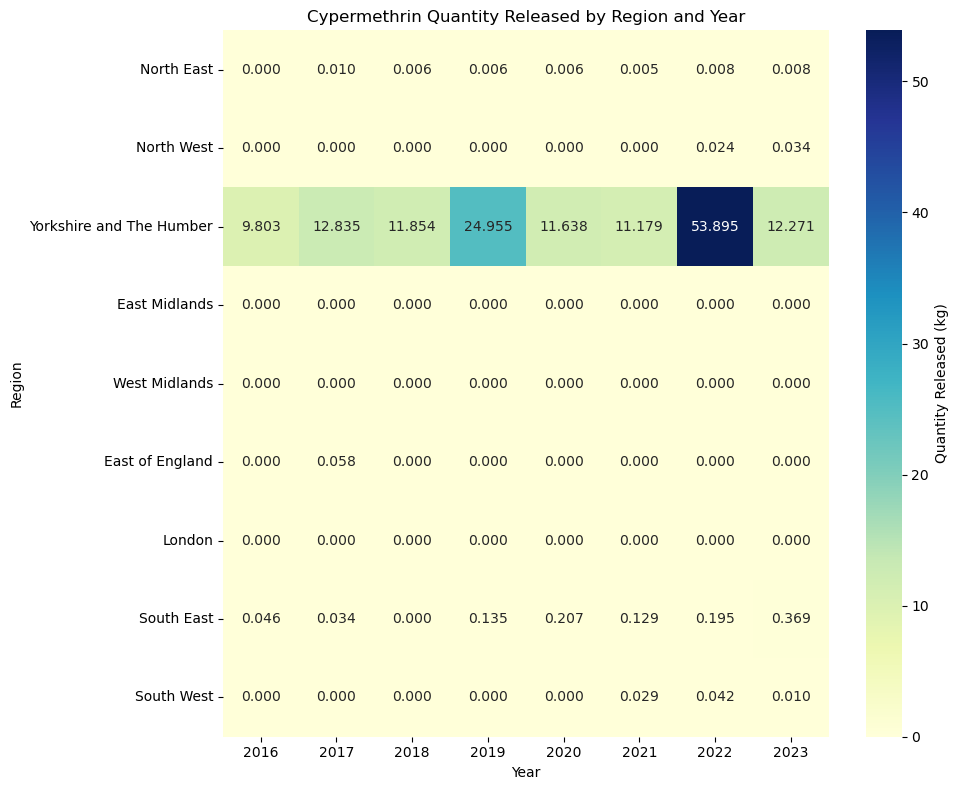

In [39]:
# 8\. 区域-年份热力图 —— 使用 reindex 保证所有 regions_ordered 和年度都展示
import seaborn as sns
heatmap_data = (
    cyper.groupby(['region','year'])['quantity_released']
         .sum()
         .unstack(fill_value=0)
         .reindex(index=regions_ordered, columns=sorted(cyper['year'].unique()), fill_value=0)
)
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlGnBu', cbar_kws={'label':'Quantity Released (kg)'})
plt.title('Cypermethrin Quantity Released by Region and Year')
plt.xlabel('Year')
plt.ylabel('Region')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show() 

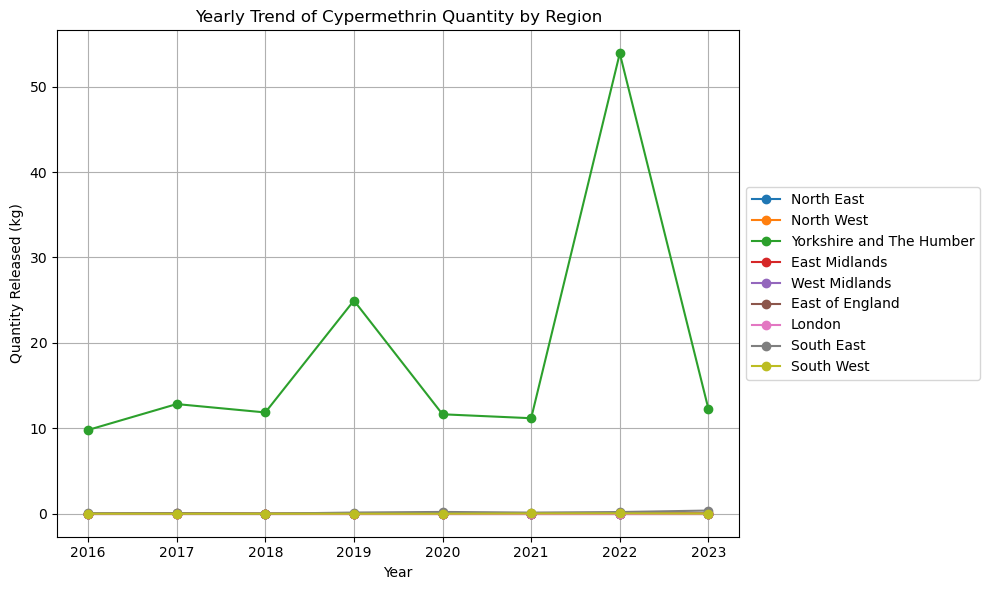

In [45]:
# 9. 各Region按年份变化折线图 —— 多条折线展示
# 构建按 Region×Year 求和后的 DataFrame tmp（确保与热力图一致）
tmp = (
    cyper.groupby(['region','year'])['quantity_released']
         .sum()
         .unstack(fill_value=0)
         .reindex(index=regions_ordered, columns=sorted(cyper['year'].unique()), fill_value=0)
)

plt.figure(figsize=(10, 6))
for region in regions_ordered:
    series = tmp.loc[region]
    plt.plot(series.index, series.values, marker='o', label=region)

plt.title('Yearly Trend of Cypermethrin Quantity by Region')
plt.xlabel('Year')
plt.ylabel('Quantity Released (kg)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()


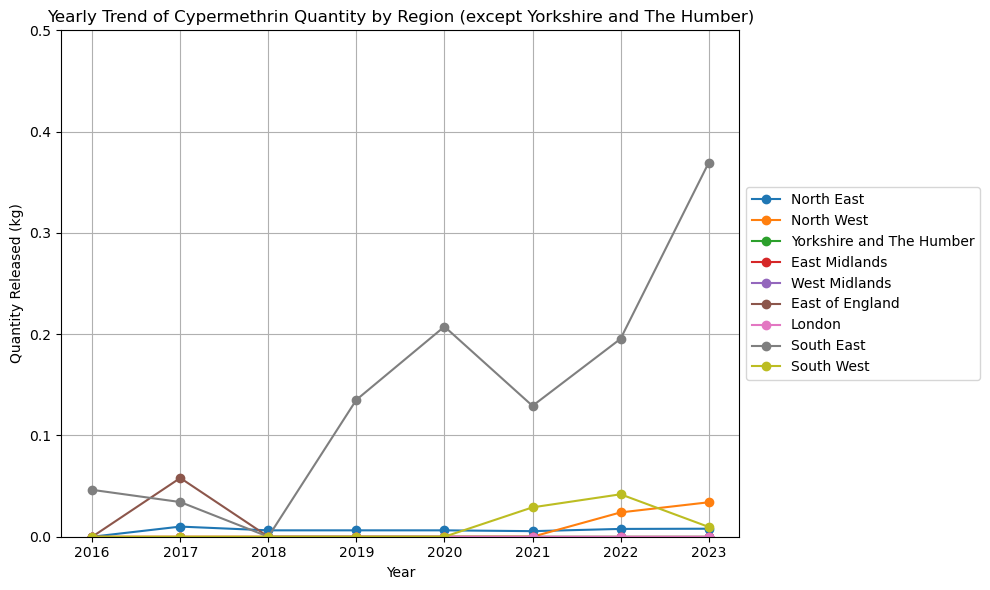

In [55]:
# 9. 各Region按年份变化折线图 —— 多条折线展示，并细化 y 轴区间
# 构建按 Region×Year 求和后的 DataFrame tmp（确保与热力图一致）
tmp = (
    cyper.groupby(['region','year'])['quantity_released']
         .sum()
         .unstack(fill_value=0)
         .reindex(index=regions_ordered, columns=sorted(cyper['year'].unique()), fill_value=0)
)

plt.figure(figsize=(10, 6))
for region in regions_ordered:
    series = tmp.loc[region]
    plt.plot(series.index, series.values, marker='o', label=region)

plt.title('Yearly Trend of Cypermethrin Quantity by Region (except Yorkshire and The Humber)')
plt.xlabel('Year')
plt.ylabel('Quantity Released (kg)')
# 限制 y 轴范围到 0-10，提高低值区域可见度
plt.ylim(0, 0.5)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()